In [1]:
# General
import os, requests, time
import numpy as np
import pandas as pd
import datetime as dt
import tables as tb
pd.options.display.max_columns = 24

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

# Chicago - Taxi trips

Raw data summary:
- **Number of files and size**: 74GB in 8 files.
- **Time span**: 2013 - 2020.
- **Total number of trips**: > 193 M.
- **Total number of zones**: 801.

## Trip counts and locations

In [352]:
df_colnames = pd.read_excel('../data/chicago/other/chicago_colnames.xlsx', index_col=0)
df_colnames.shape

(8, 12)

Count of taxi trips per year:

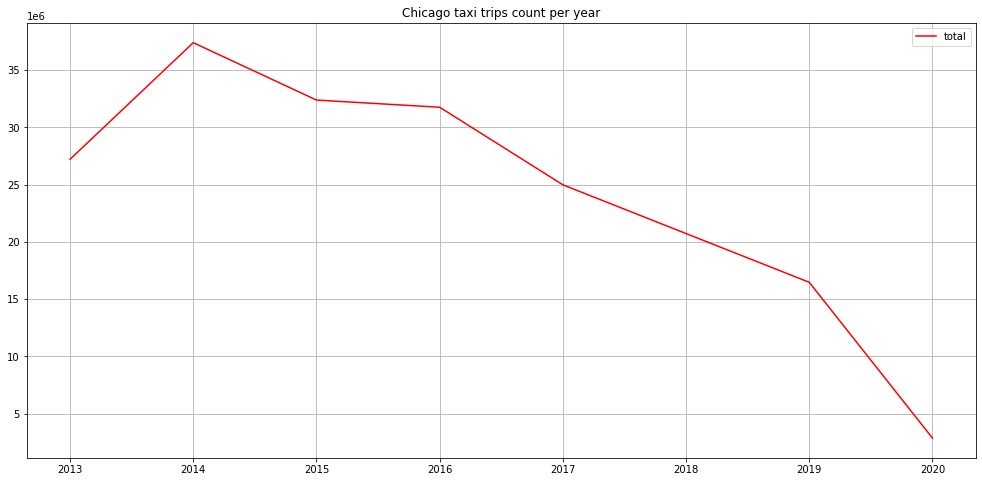

In [353]:
fig, ax = plt.subplots()
fig.set_size_inches(17, 8)
ax.plot(range(2013, 2021), df_colnames.loc[:, 'shape'].apply(eval).str[0], label='total', c='red')

ax.legend()
ax.grid()
ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6))
ax.set_title('Chicago taxi trips count per year')
plt.show()

Unique pick-up and drop-off **locations** for taxi trips per month:

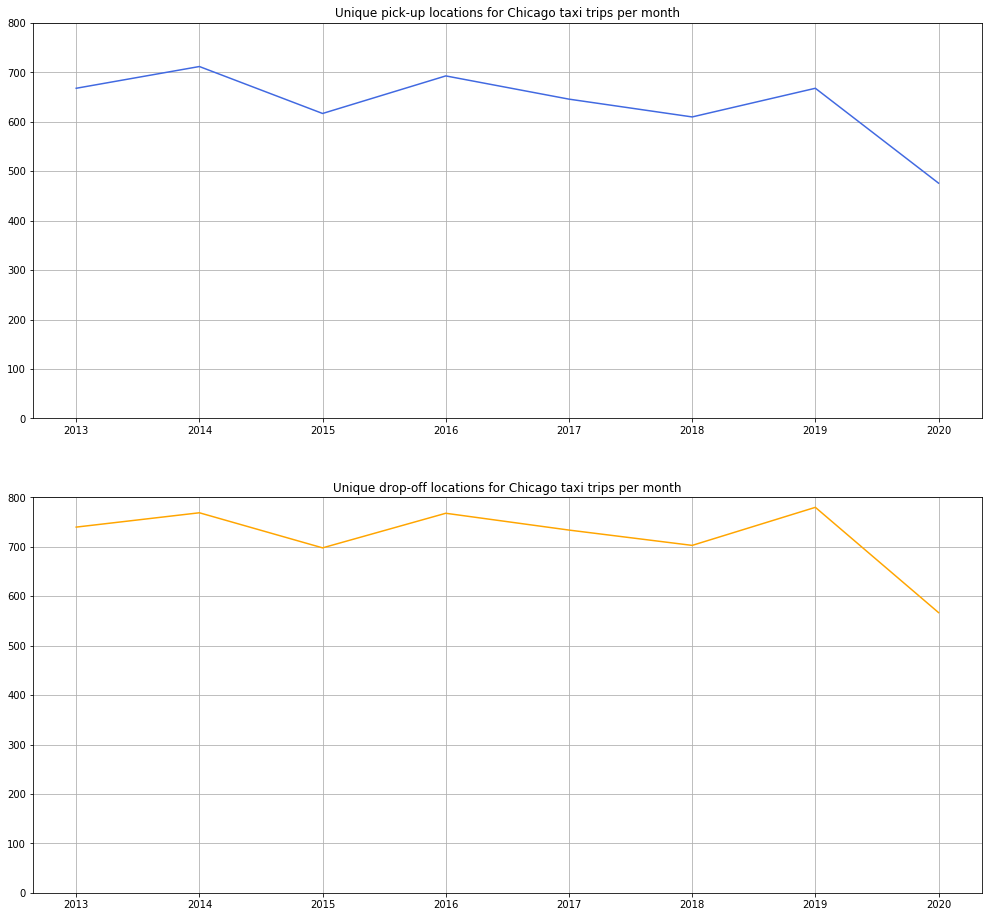

In [355]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(17, 16)

ax[0].plot(range(2013, 2021), df_colnames.n_pickup, c='royalblue')
ax[0].set_title('Unique pick-up locations for Chicago taxi trips per month')
ax[0].grid()
ax[0].set_ylim(0, 800)

ax[1].plot(range(2013, 2021), df_colnames.n_dropoff, c='orange')
ax[1].set_title('Unique drop-off locations for Chicago taxi trips per month')
ax[1].grid()
ax[1].set_ylim(0, 800)

plt.show()

## Analysing the shapefile and zones 

In [2]:
from shapely.wkt import loads as load_wkt
from itertools import combinations
from matplotlib.colorbar import ColorbarBase

Chicago zones (801) from shapefile:

In [3]:
def plt_zones(fname, colors='plain', cmap=None, title='', fig=None, ax=None):
    # Depending on the city, fix the number of zones and lon-lat ranges
    offset = 0.03
    if 'chicago' in fname:
        n_zones = 801
        zone_col = 'name10'
        lon_lat_ranges = [-87.913625 - offset, -87.534903 + offset,
                           41.650222 - offset,  42.021224 + offset]
    elif 'nyc' in fname:
        n_zones = 263
        zone_col = 'OBJECTID'
        lon_lat_ranges = [-74.300271 - offset, -73.642545 + offset,
                           40.481329 - offset,  40.916730 + offset]
    # Possible colors: uniform, random or cmap
    if colors == 'plain':
        edgecolor = 'white'
        facecolor = [0.7, .2, 0.1, 0.4]
    elif colors == 'random':
        edgecolor = 'black'
        facecolor = list(np.random.rand(n_zones, 3))
    elif colors == 'cmap':
        # Caveat: cmap expects normalized values
        edgecolor = 'black'
        facecolor = list(plt.cm.get_cmap('YlOrRd')(cmap))
    # Create figure and axes if necessary
    if fig is None or ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        fig.set_size_inches(10, 10)
        if colors == 'cmap':
            fig.subplots_adjust(left=0.05, bottom=0, right=0.85, top=1, wspace=None, hspace=None)
            cax = fig.add_axes([0.9, 0.165, 0.02, 0.67])
            cb = ColorbarBase(cax, cmap=plt.cm.get_cmap('YlOrRd'), norm=Normalize(vmin=0, vmax=1))
            #label='Normalised taxi demand', spacing='uniform'/'proportional'
            cb.set_label('Normalised taxi demand', labelpad=10)
    # Prepare map features (ranges, land, water...)
    ax.add_feature(cfeature.LAND, alpha=0.3)
    ax.add_feature(cfeature.OCEAN, alpha=0.2)
    ax.add_feature(cfeature.LAKES, alpha=0.2)
    ax.set_extent(lon_lat_ranges)
    # Load and sort map
    df_shp = pd.DataFrame({'zone': [r.attributes[zone_col] for r in Reader(fname).records()],
                           'poly': Reader(fname).geometries()})
    df_shp.zone = df_shp.zone.astype(float)
    df_shp.sort_values('zone', inplace=True)
    shape_feature = ShapelyFeature(df_shp.poly, ccrs.PlateCarree(),
                                   edgecolor=edgecolor, facecolor=facecolor)
    ax.add_feature(shape_feature)
    ax.set_title(title)
    
    return fig, ax

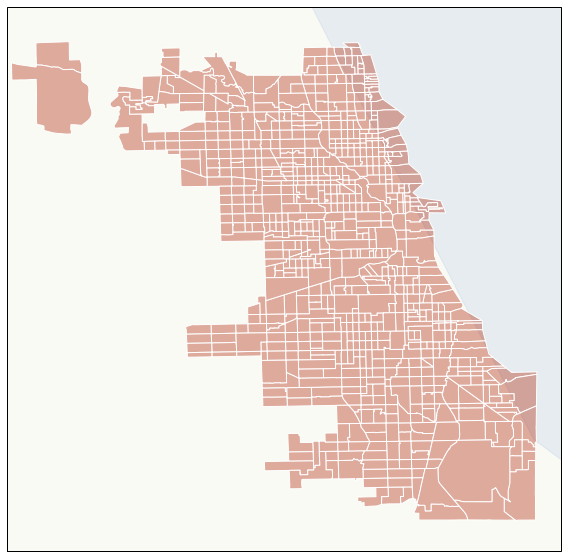

In [477]:
fname = '../data/chicago/other/chicago-shp/geo_export_f66f96e6-df96-4ae7-bd5e-883ddff6cf75.shp'
fig, ax = plt_zones(fname)

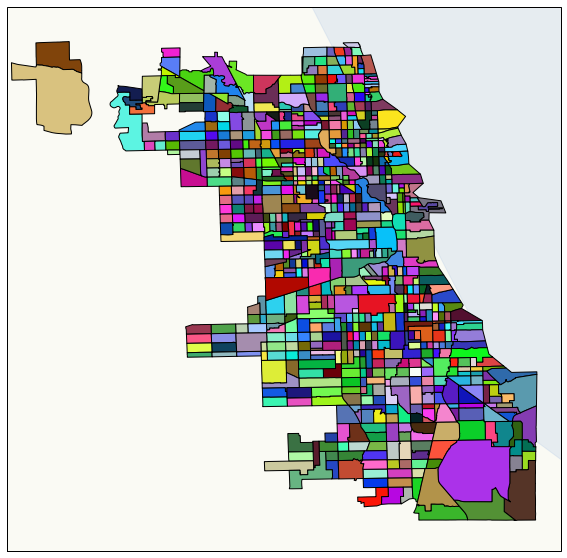

In [478]:
fname = '../data/chicago/other/chicago-shp/geo_export_f66f96e6-df96-4ae7-bd5e-883ddff6cf75.shp'
fig, ax = plt_zones(fname, colors='random')

Load lookup CSV file with the zones:

In [4]:
df_lu = pd.read_csv('../data/chicago/other/taxi_zone_lookup.csv')
df_lu.shape

(801, 10)

In [31]:
for c in df_lu.columns:
    print(c, '->', df_lu[c].nunique())

the_geom -> 801
STATEFP10 -> 1
COUNTYFP10 -> 1
TRACTCE10 -> 801
GEOID10 -> 801
NAME10 -> 801
NAMELSAD10 -> 801
COMMAREA -> 77
COMMAREA_N -> 77
NOTES -> 7


In [32]:
(df_lu.COMMAREA == df_lu.COMMAREA_N).sum()

801

In [33]:
df_lu.NOTES.unique()

array([nan, 'Half in CA 64 (Midway Airport)', 'Small area in CA 43',
       'Small unpopulated area in CA 32',
       'Partially outside City Boundary', 'Small area in CA 24',
       'Partially outside City Boundary (almost all)',
       "Partially outside City Boundary (O'Hare)"], dtype=object)

In [34]:
df_lu.NAME10.head(10).values

array([8424.  , 8403.  , 8411.  , 8412.  , 8390.  , 8382.  , 6503.01,
       5305.03, 7608.03,  306.01])

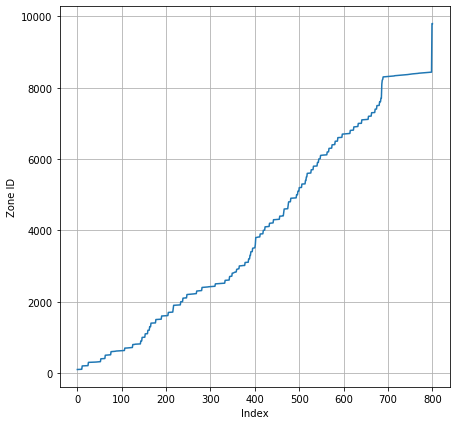

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.plot(range(801), df_lu.NAME10.sort_values())
ax.set_xlabel('Index')
ax.set_ylabel('Zone ID')
ax.grid()
plt.show()

Populate dictionary with multipolygons:

In [5]:
poly_d = dict()
for r in df_lu.iterrows():
    poly = r[1]['the_geom']
    zone = r[1]['NAME10']
    poly_d[zone] = load_wkt(poly)
len(poly_d)

801

Check that no pairs of multipolygons crosses or are contained in one another.  
There are ${801\choose 2} = 320400$ combinations to check:

In [406]:
for zone1, zone2 in combinations(df_lu.NAME10.values, 2):
    if poly_d[zone1].crosses(poly_d[zone2]):
        print(zone1, 'crosses', zone2)
    if poly_d[zone1].contains(poly_d[zone2]):
        print(zone1, 'contains', zone2)
    if poly_d[zone2].contains(poly_d[zone1]):
        print(zone2, 'contains', zone1)

From centroids to zones (pick-up locations **in 2020**):

In [39]:
df['Pickup Centroid Location'].nunique()

476

In [40]:
def zone_lookup(loc):
    if loc is np.nan:
        return np.nan
    for key in poly_d.keys():
        if poly_d[key].contains(load_wkt(loc)):
            return key
    return np.nan

Create additional dataframe to store the mapping `centroid -> zone`:

In [42]:
df_zone = pd.DataFrame()
df_zone['location'] = df['Pickup Centroid Location'].unique()
tic = time.time()
df_zone.loc[:, 'pu_zone'] = df_zone.location.apply(zone_lookup)
print('{}'.format(str(dt.timedelta(seconds=time.time() - tic))))

0:00:03.372926


In [43]:
df_zone.shape, df_zone.pu_zone.nunique()

((477, 2), 437)

In [44]:
print(df_zone[df_zone.pu_zone.duplicated(keep=False)]['pu_zone'].nunique())
display(df_zone[df_zone.pu_zone.duplicated(keep=False)].sort_values('pu_zone').head(6))
df_zone[df_zone.pu_zone.duplicated(keep=False)].sort_values('pu_zone').tail(6)

38


,location,pu_zone
219,POINT (-87.6727239593 42.0090182269),107.02
19,POINT (-87.6701668569 42.0096228806),107.02
36,POINT (-87.6950125892 42.001571027),206.02
178,POINT (-87.6936374936 42.0013159243),206.02
203,POINT (-87.6649377243 41.9872255578),305.00
30,POINT (-87.6634164054 41.9867117999),305.00


,location,pu_zone
97,POINT (-87.6591665992 41.8090182499),8426.0
423,POINT (-87.6516929533 41.8162234797),8426.0
5,POINT (-87.913624596 41.9802643146),9800.0
43,POINT (-87.9030396611 41.9790708201),9800.0
12,NaN,NaN
159,POINT (-87.8773053996 41.9827750091),NaN


There is one centroid that belongs to no zone:

In [45]:
df_zone.loc[df_zone.pu_zone.isna()]

,location,pu_zone
12,NaN,NaN
159,POINT (-87.8773053996 41.9827750091),NaN


415


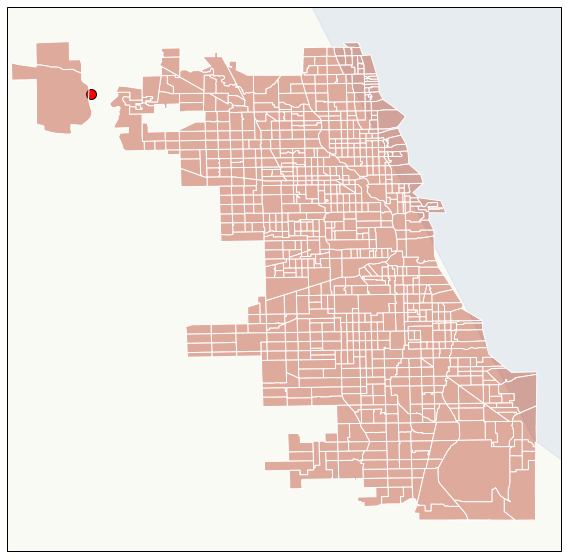

In [63]:
print(df[df['Pickup Centroid Location'] == 'POINT (-87.8773053996 41.9827750091)'].shape[0])
fname = '../data/chicago/other/chicago-shp/geo_export_f66f96e6-df96-4ae7-bd5e-883ddff6cf75.shp'
fig, ax = plt_zones(fname)
ax.scatter([-87.8773053996], [41.9827750091], color='r', edgecolor='black', s=100)
plt.show()

Add `pu_zone` column to the original 2020 dataframe: 

In [51]:
df = pd.merge(df, df_zone, left_on='Pickup Centroid Location', right_on='location')
df.pu_zone.nunique()

437

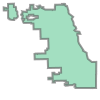

In [53]:
from shapely.ops import unary_union
chicago = unary_union(list(poly_d.values()))
display(chicago)

## Analysing missing fields for all files

In [541]:
df_na = pd.DataFrame(columns=['n_trips', 'pu_na_time', 'do_na_time',
                              'pu_na_loc', 'do_na_loc', 'na_any_loc',
                              'pu_na_zone', 'do_na_zone', 'na_any_zone'])

times_d = dict()
for trip_time in ['Trip Start Timestamp', 'Trip End Timestamp']:
    times_d[trip_time] = dict()
    for t in ['hours', 'minutes', 'seconds']:
        times_d[trip_time][t] = set()

def get_zones(df):
    df_pu, df_do = pd.DataFrame(), pd.DataFrame()
    df_pu['pu_location'] = df['Pickup Centroid Location'].unique()
    df_do['do_location'] = df['Dropoff Centroid  Location'].unique()
    df_pu.loc[:, 'pu_zone'] = df_pu.pu_location.apply(zone_lookup)
    df_do.loc[:, 'do_zone'] = df_do.do_location.apply(zone_lookup)
    return df_pu, df_do

for year in url_d.keys():
    print('Working on {}...'.format(year))
    df_curr = pd.read_csv('../data/chicago/raw/{}_taxi.csv'.format(year))
    # Convert to datetime
    df_curr['Trip Start Timestamp'] = pd.to_datetime(df_curr['Trip Start Timestamp'])
    df_curr['Trip End Timestamp'] = pd.to_datetime(df_curr['Trip End Timestamp'])
    # Add zones
    df_pu, df_do = get_zones(df_curr)
    df_curr = pd.merge(df_curr, df_pu, left_on='Pickup Centroid Location', right_on='pu_location')
    df_curr = pd.merge(df_curr, df_do, left_on='Dropoff Centroid  Location', right_on='do_location')
    # Make counts
    df_na.loc[year, 'n_trips'] = df_curr.shape[0]
    df_na.loc[year, 'pu_na_time'] = df_curr['Trip Start Timestamp'].isna().sum()
    df_na.loc[year, 'do_na_time'] = df_curr['Trip End Timestamp'].isna().sum()
    df_na.loc[year, 'pu_na_loc'] = df_curr['Pickup Centroid Location'].isna().sum()
    df_na.loc[year, 'do_na_loc'] = df_curr['Dropoff Centroid  Location'].isna().sum()
    df_na.loc[year, 'na_any_loc'] = df_curr[(df_curr['Trip Start Timestamp'].isna()) | \
                                            (df_curr['Trip End Timestamp'].isna()) | \
                                            (df_curr['Pickup Centroid Location'].isna()) | \
                                            (df_curr['Dropoff Centroid  Location'].isna())].shape[0]
    df_na.loc[year, 'pu_na_zone'] = df_curr['pu_zone'].isna().sum()
    df_na.loc[year, 'do_na_zone'] = df_curr['do_zone'].isna().sum()
    df_na.loc[year, 'na_any_zone'] = df_curr[(df_curr['Trip Start Timestamp'].isna()) | \
                                             (df_curr['Trip End Timestamp'].isna()) | \
                                             (df_curr['pu_zone'].isna()) | \
                                             (df_curr['do_zone'].isna())].shape[0]
    # Check hours, minutes and seconds
    for trip_time in ['Trip Start Timestamp', 'Trip End Timestamp']:
        times_d[trip_time]['hours'].update(df_curr.loc[~df_curr[trip_time].isna(), trip_time].dt.hour.unique())
        times_d[trip_time]['minutes'].update(df_curr.loc[~df_curr[trip_time].isna(), trip_time].dt.minute.unique())
        times_d[trip_time]['seconds'].update(df_curr.loc[~df_curr[trip_time].isna(), trip_time].dt.second.unique())

Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...


In [539]:
df_na.loc['total', :] = df_na.loc['2013':'2020', :].sum(axis=0)
for c in df_na.columns:
    df_na.loc['perc', c] = round(df_na.loc['total', c] / df_na.loc['total', 'n_trips'] * 100,1)
    #df_na[c] = df_na[c].astype(int)
df_na

,n_trips,pu_na_time,do_na_time,pu_na_loc,do_na_loc,na_any_loc,pu_na_zone,do_na_zone,na_any_zone
2013,27217716.0,0.0,3433.0,4651708.0,5381631.0,5548048.0,4652210.0,5413225.0,5579084.0
2014,37395436.0,0.0,5869.0,4593881.0,5194875.0,5371081.0,4596042.0,5265362.0,5440922.0
2015,32385875.0,0.0,3591.0,4327016.0,4898485.0,5064279.0,4328100.0,4961782.0,5126720.0
2016,31759339.0,0.0,2414.0,4284508.0,4500700.0,5029893.0,4290007.0,4583707.0,5108457.0
2017,24988003.0,0.0,662.0,2297398.0,2686162.0,2919242.0,2301861.0,2757326.0,2987627.0
2018,20732088.0,0.0,350.0,1424219.0,1814846.0,1967221.0,1429318.0,1884606.0,2034905.0
2019,16477365.0,0.0,545.0,1235952.0,1599600.0,1790495.0,1237986.0,1658649.0,1847973.0
2020,2880334.0,0.0,253.0,199774.0,252518.0,288855.0,200189.0,258580.0,294648.0
total,193836156.0,0.0,17117.0,23014456.0,26328817.0,27979114.0,23035713.0,26783237.0,28420336.0
perc,100.0,0.0,0.0,11.9,13.6,14.4,11.9,13.8,14.7


In [540]:
print(times_d)

{'Trip Start Timestamp': {'hours': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}, 'minutes': {0, 45, 30, 15}, 'seconds': {0}}, 'Trip End Timestamp': {'hours': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}, 'minutes': {0, 45, 30, 15}, 'seconds': {0}}}


## Some EDA for 2020

In [29]:
df = pd.read_csv('../data/chicago/raw/2020_taxi.csv')
df.shape

(2880334, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880334 entries, 0 to 2880333
Data columns (total 23 columns):
Trip ID                       object
Taxi ID                       object
Trip Start Timestamp          object
Trip End Timestamp            object
Trip Seconds                  float64
Trip Miles                    float64
Pickup Census Tract           float64
Dropoff Census Tract          float64
Pickup Community Area         float64
Dropoff Community Area        float64
Fare                          float64
Tips                          float64
Tolls                         float64
Extras                        float64
Trip Total                    float64
Payment Type                  object
Company                       object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location      object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location    object
dtypes: float64(15), 

In [7]:
df['Trip Start Timestamp'].nunique()

14567

In [438]:
print('Unique pick-up hours:', pd.to_datetime(df['Trip Start Timestamp']).dt.hour.unique())
print('Unique drop-off hours:', pd.to_datetime(df['Trip End Timestamp']).dt.hour.unique())
print('Unique pick-up minutes:', pd.to_datetime(df['Trip Start Timestamp']).dt.minute.unique())
print('Unique drop-off minutes:', pd.to_datetime(df['Trip End Timestamp']).dt.minute.unique())
print('Unique pick-up seconds:', pd.to_datetime(df['Trip Start Timestamp']).dt.second.unique())
print('Unique drop-off seconds:', pd.to_datetime(df['Trip End Timestamp']).dt.second.unique())

Unique pick-up hours: [ 0  1  2  3  4  5  7  9 11 12 13 15 16 17 18 19 20 21 22 23  8 10 14  6]
Unique drop-off hours: [ 0.  1.  2.  3.  4.  5.  6.  7.  9. 11. 12. 13. 15. 16. 17. 18. 19. 20.
 21. 22. 23.  8. 10. 14. nan]
Unique pick-up minutes: [ 0 15 30 45]
Unique drop-off minutes: [30. 15.  0. 45. nan]
Unique pick-up seconds: [0]
Unique drop-off seconds: [ 0. nan]


In [5]:
df[['Pickup Centroid Longitude', 'Pickup Centroid Latitude']].apply([np.min, np.max, pd.Series.nunique])

,Pickup Centroid Longitude,Pickup Centroid Latitude
amin,-87.913625,41.650222
amax,-87.534903,42.021224
nunique,475.000000,475.000000


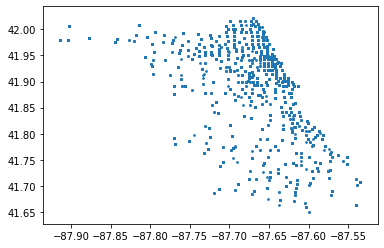

In [4]:
plt.scatter(df['Pickup Centroid Longitude'], df['Pickup Centroid Latitude'], s=3)
plt.show()

Some zones and their trip counts:

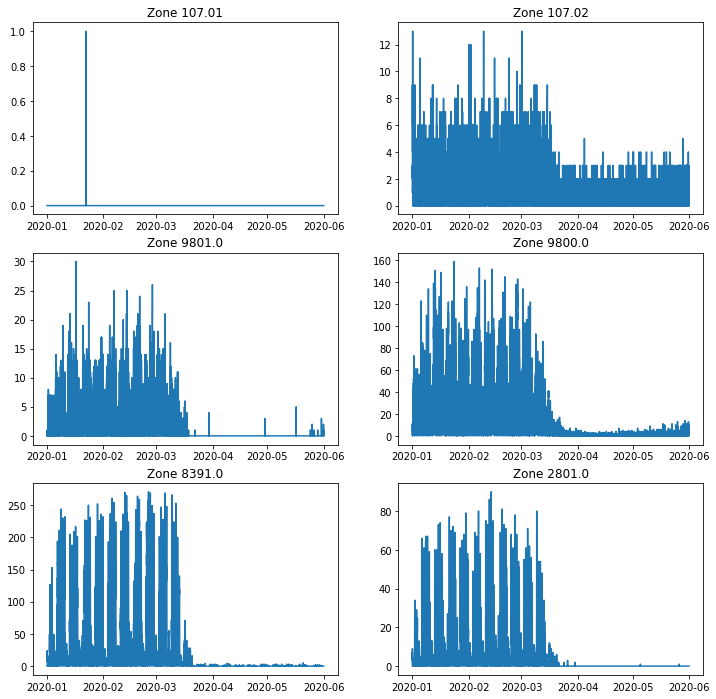

In [389]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(12, 12)
ax = axs.ravel()
for idx, zone in enumerate([107.01, 107.02, 9801.0, 9800.0, 8391.0, 2801.0]):
    ax[idx].plot(df_pivot[zone])
    ax[idx].set_title('Zone {}'.format(zone))

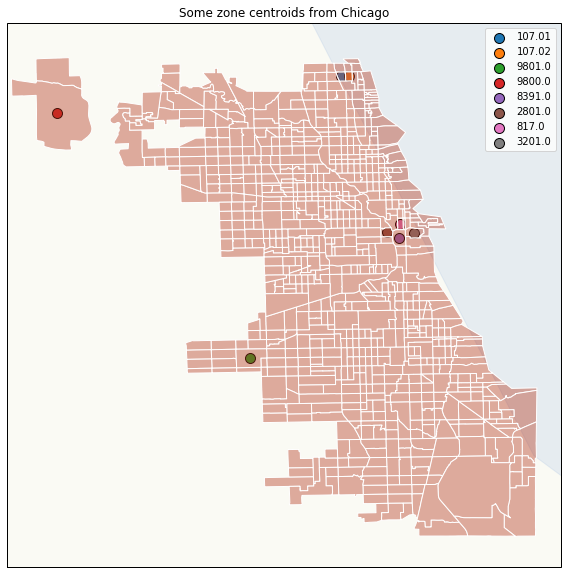

In [8]:
fname = '../data/chicago/other/chicago-shp/geo_export_f66f96e6-df96-4ae7-bd5e-883ddff6cf75.shp'
fig, ax = plt_zones(fname, title='Some zone centroids from Chicago')
for zone in [107.01, 107.02, 9801.0, 9800.0, 8391.0, 2801.0, 817.0, 3201.0]:
    lon, lat = poly_d[zone].centroid.x, poly_d[zone].centroid.y
    ax.scatter(lon, lat, edgecolor='black', s=100, label=zone)
    ax.legend()
plt.show()
fig.savefig('./graphs/chicago_zones.pdf', bbox_inches='tight')

## Some EDA for all years

Plot of the arrays (each year):

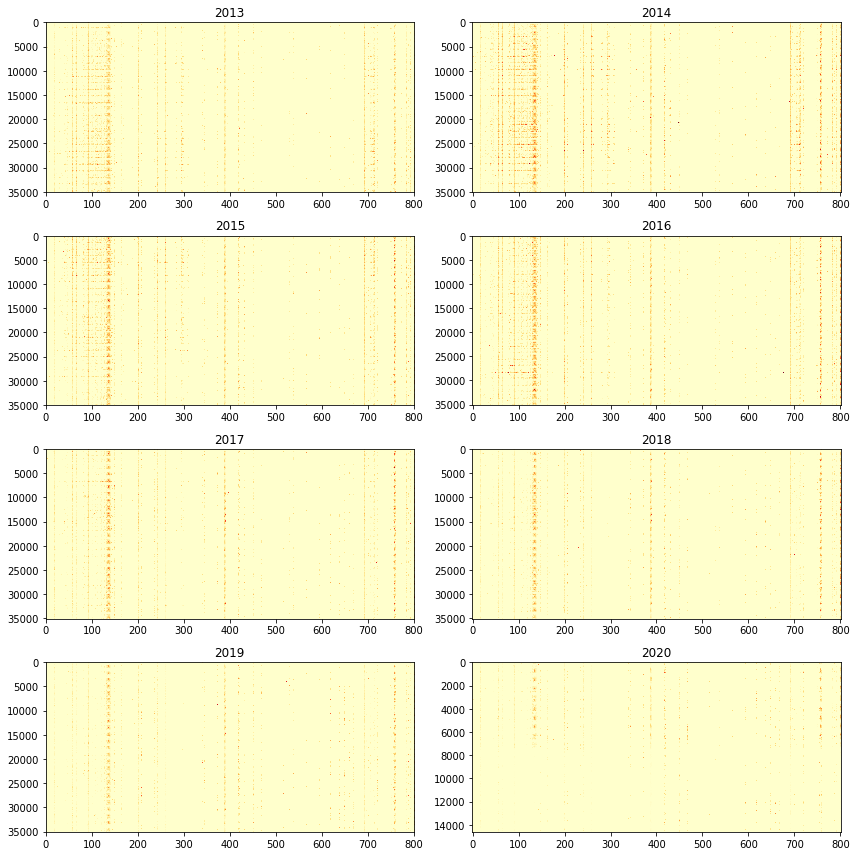

In [490]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(12, 12)
ax = axs.ravel()
out_path = '../data/chicago/clean/chicago_pu_15m_norm.h5'
with tb.open_file(out_path, mode='r') as hdf5_file:
    for idx, year in enumerate(range(2013, 2021)):
        ax[idx].imshow(hdf5_file.get_node('/{:04}'.format(year))[:].astype(float), cmap='YlOrRd')
        ax[idx].set_title(year)
        ax[idx].set_aspect('auto')
fig.tight_layout()
plt.show()

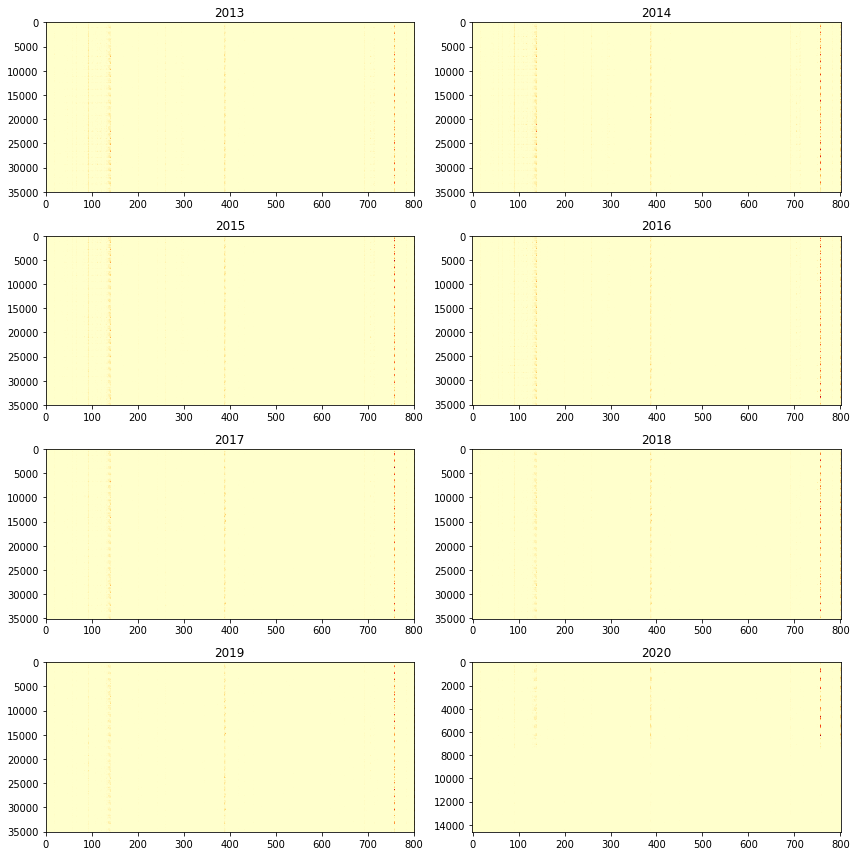

In [491]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(12, 12)
ax = axs.ravel()
out_path = '../data/chicago/clean/chicago_pu_15m_norm_abs.h5'
with tb.open_file(out_path, mode='r') as hdf5_file:
    for idx, year in enumerate(range(2013, 2021)):
        ax[idx].imshow(hdf5_file.get_node('/{:04}'.format(year))[:].astype(float), cmap='YlOrRd')
        ax[idx].set_title(year)
        ax[idx].set_aspect('auto')
fig.tight_layout()
plt.show()

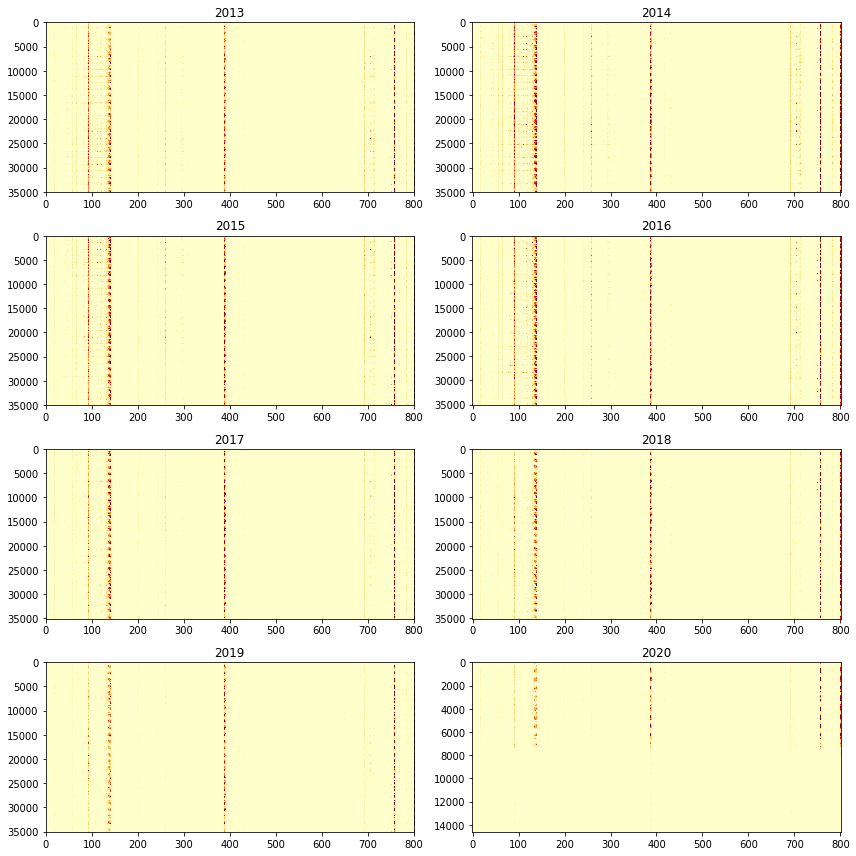

In [493]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(12, 12)
ax = axs.ravel()
out_path = '../data/chicago/clean/chicago_pu_15m_norm_abs_050.h5'
with tb.open_file(out_path, mode='r') as hdf5_file:
    for idx, year in enumerate(range(2013, 2021)):
        ax[idx].imshow(hdf5_file.get_node('/{:04}'.format(year))[:].astype(float), cmap='YlOrRd')
        ax[idx].set_title(year)
        ax[idx].set_aspect('auto')
fig.tight_layout()
plt.show()

Histograms of trip counts per year (every 15min): 

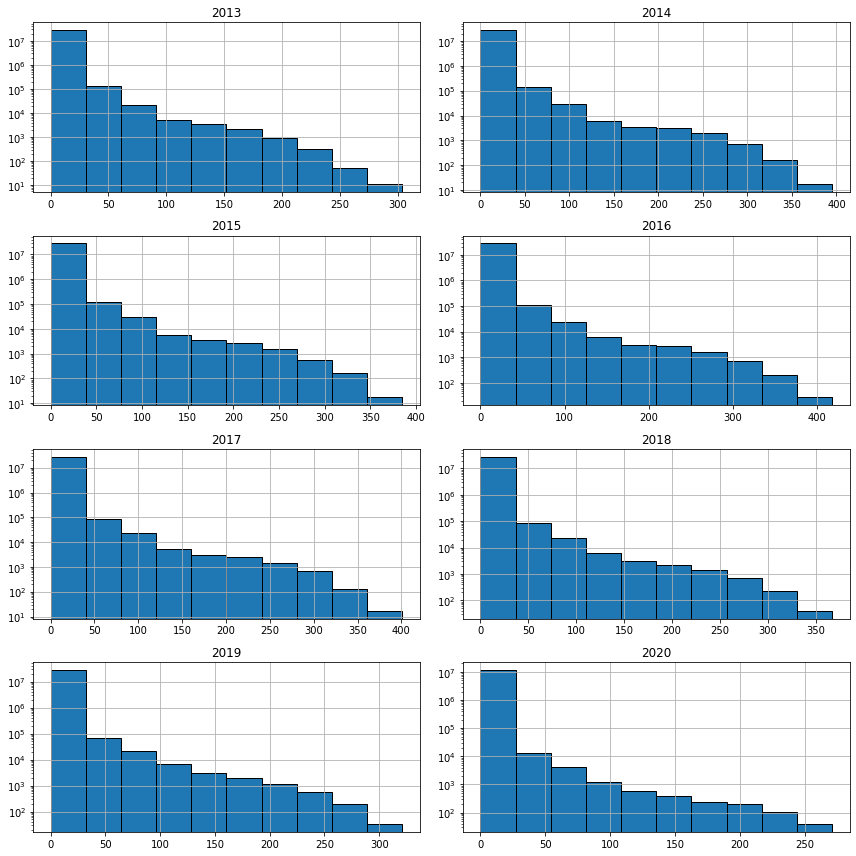

In [575]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(12, 12)
ax = axs.ravel()
out_path = '../data/chicago/clean/chicago_pu_15m.h5'
with tb.open_file(out_path, mode='r') as hdf5_file:
    for idx, year in enumerate(range(2013, 2021)):
        ax[idx].hist(hdf5_file.get_node('/{:04}'.format(year))[:].ravel(), edgecolor='k')
        ax[idx].set_title(year)
        ax[idx].set_yscale('log')
        ax[idx].grid()
fig.tight_layout()
plt.show()

Histograms of trip counts per zone (every 15min): 

In [239]:
def plt_hist(in_path, out_path):
    fig, axs = plt.subplots(40, 20)
    fig.set_size_inches(48, 96)
    ax = axs.ravel()
    with tb.open_file(in_path, mode='r') as hdf5_file:
        for idx, zone in enumerate(sorted(poly_d.keys())[:800]):
            arr = np.empty(0)
            for year in range(2013, 2021):
                arr = np.concatenate((arr, hdf5_file.get_node('/{:04}'.format(year))[:, idx]))
            ax[idx].hist(arr, edgecolor='k')
            ax[idx].set_title(zone)
            ax[idx].set_yscale('log')
            #ax[idx].grid()
    fig.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)
    #plt.show()

In [494]:
paths = [('../data/chicago/clean/chicago_pu_15m_count.h5', './graphs/chicago_hist_count_per_zone.png'),
         ('../data/chicago/clean/chicago_pu_15m_norm.h5', './graphs/chicago_hist_norm_per_zone.png'),
         ('../data/chicago/clean/chicago_pu_15m_norm_abs.h5', './graphs/chicago_hist_norm_abs.png'),
         ('../data/chicago/clean/chicago_pu_15m_norm_abs_050.h5', './graphs/chicago_hist_norm_abs_050.png'),
         ('../data/chicago/clean/chicago_pu_15m_stand.h5', './graphs/chicago_hist_stand_per_zone.png'),
         ('../data/chicago/clean/chicago_pu_15m_stand_abs.h5', './graphs/chicago_hist_stand_abs.png')]

for in_path, out_path in paths:
    plt_hist(in_path, out_path)

## Animated taxi demand plot

In [97]:
import matplotlib.animation as animation
from matplotlib.colors import Normalize

In [98]:
def idx_to_datetime(idx, year, freq=15):
    # Frequency expressed in minutes
    base = dt.datetime(year, 1, 1, 0, 0)
    return base + dt.timedelta(minutes=freq * idx)

def datetime_to_idx(date, freq=15):
    # Frequency expressed in minutes
    base = dt.datetime(date.year, 1, 1, 0, 0)
    return int((date - base).total_seconds() / (60 * freq))

print(idx_to_datetime(520, 2020))
datetime_to_idx(dt.datetime(year, 3, 15, 0, 0))

2020-01-06 10:00:00


7104

In [488]:
def update(frame, spath, arr, start, fig, ax):
    ax.clear()
    time = start + dt.timedelta(minutes=15 * frame)
    title = 'Mobility demand in Chicago on the {}'.format(time.strftime('%d/%m/%Y at %H:%M'))
    plt_zones(spath, colors='cmap', cmap=arr[frame], title=title, fig=fig, ax=ax)

def mobility_map(start, end, fpath, spath):
    id_start = datetime_to_idx(start)
    id_end = datetime_to_idx(end)
    with tb.open_file(fpath, mode='r') as hdf5_file:
        # Get min and max in order to normalize the data
        vmin, vmax = np.infty, -np.infty
        for year in range(2013, 2021):
            arr = hdf5_file.get_node('/{:04}'.format(year))[:]
            vmin, vmax = min(arr.min(), vmin), max(arr.max(), vmax)
        # Get slice of data to plot
        arr = hdf5_file.get_node('/{:04}'.format(start.year))[id_start:id_end]
    arr = Normalize(vmin=vmin, vmax=vmax)(arr)
    fig, ax = plt_zones(fname, colors='cmap', cmap=arr[0])
    anim = animation.FuncAnimation(fig, update, frames=arr.shape[0], fargs=[spath, arr, start, fig, ax])
    fsave = './graphs/animations/{}_{}.mp4'.format(start.strftime('%Y%m%d'),
                                                   os.path.basename(os.path.splitext(fpath)[0]))
    anim.save(fsave, fps=4, dpi=180)
    plt.close(fig)

In [489]:
fpath = '../data/chicago/clean/chicago_pu_15m.h5'

start = dt.datetime(2019, 11, 15, 0, 0)
end = dt.datetime(2019, 11, 16, 23, 45)
for f in ['', '_norm', '_norm_abs_050', '_norm_abs', '_stand', '_stand_abs']:
    mobility_map(start, end, fpath.replace('.h5', f + '.h5'), spath)

start = dt.datetime(2019, 12, 24, 0, 0)
end = dt.datetime(2019, 12, 25, 23, 45)
for f in ['', '_norm', '_norm_abs_050', '_norm_abs', '_stand', '_stand_abs']:
    mobility_map(start, end, fpath.replace('.h5', f + '.h5'), spath)

# New York - Taxi trips

Raw data summary:
- **Number of files and size**: 291GB in 280 files.
- **Time span**: 2009 - 2019.
- **Total number of trips**: > 2600 M.
- **Total number of zones**: 263.
- **Taxi services and types of locations**:
  - yellow:
    - 2009-01 - 2016-06: longitude and latitude.
    - 2016-07 - 2016-12: unknown (few PULocations and many DOLocations).
    - 2017-01 - 2019-12: zones.
  - green:
    - 2013-08 - 2016-06: longitude and latitude.
    - 2016-07 - 2016-12: unknown (few PULocations and many DOLocations).
    - 2017-01 - 2019-12: zones.
  - fhv:
    - 2015-01 - 2016-12: zones (no drop-off).
    - 2017-01 - 2019-12: zones.
  - fhvhv:
    - 2019-02 - 2019-12: zones.

## Trips counts and locations

In [15]:
df_colnames = pd.read_excel('../data/nyc/other/nyc_colnames.xlsx', index_col=[0, 1, 2])
df_colnames.shape

(280, 6)

Count of taxi trips per month split into taxi categories:

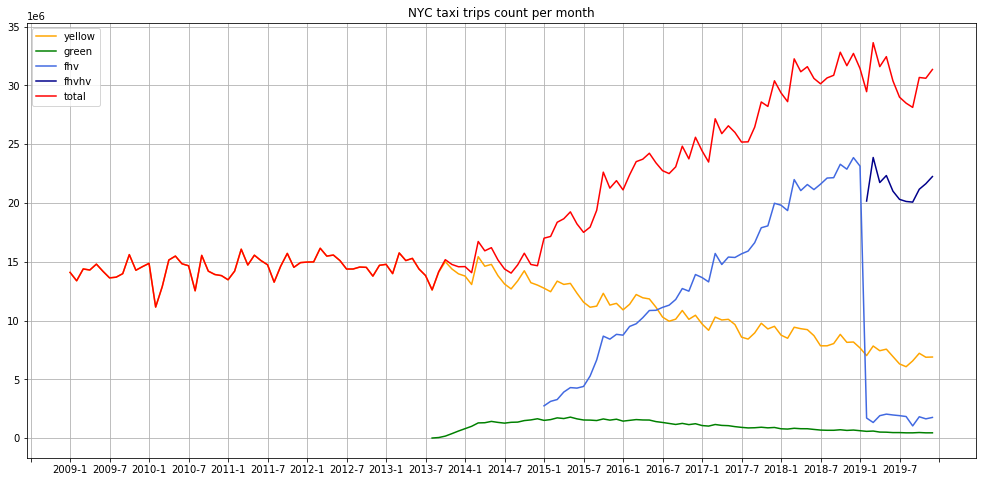

In [283]:
fig, ax = plt.subplots()
fig.set_size_inches(17, 8)
colors = {'yellow': 'orange', 'green': 'green', 'fhv': 'royalblue', 'fhvhv': 'darkblue'}
for taxi in ['yellow', 'green', 'fhv', 'fhvhv']:
    df_aux = df_colnames.loc[~(df_colnames['shape'].isna())].loc[pd.IndexSlice[:, :, taxi],]
    x = df_aux.index.get_level_values(0).astype(str) + '-' + df_aux.index.get_level_values(1).astype(str)
    ax.plot(x, df_aux.loc[:, 'shape'].str[0], label=taxi, c=colors[taxi])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(6))

x = (df_colnames.index.get_level_values(0).astype(str) + '-' + df_colnames.index.get_level_values(1).astype(str)).unique()
ax.plot(x, df_colnames.loc[:, 'shape'].str[0].groupby(level=[0, 1]).sum(), label='total', c='red')
ax.legend()
ax.grid()
ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6))
ax.set_title('NYC taxi trips count per month')
plt.show()

Unique pick-up and drop-off **locations** for taxi trips per month:

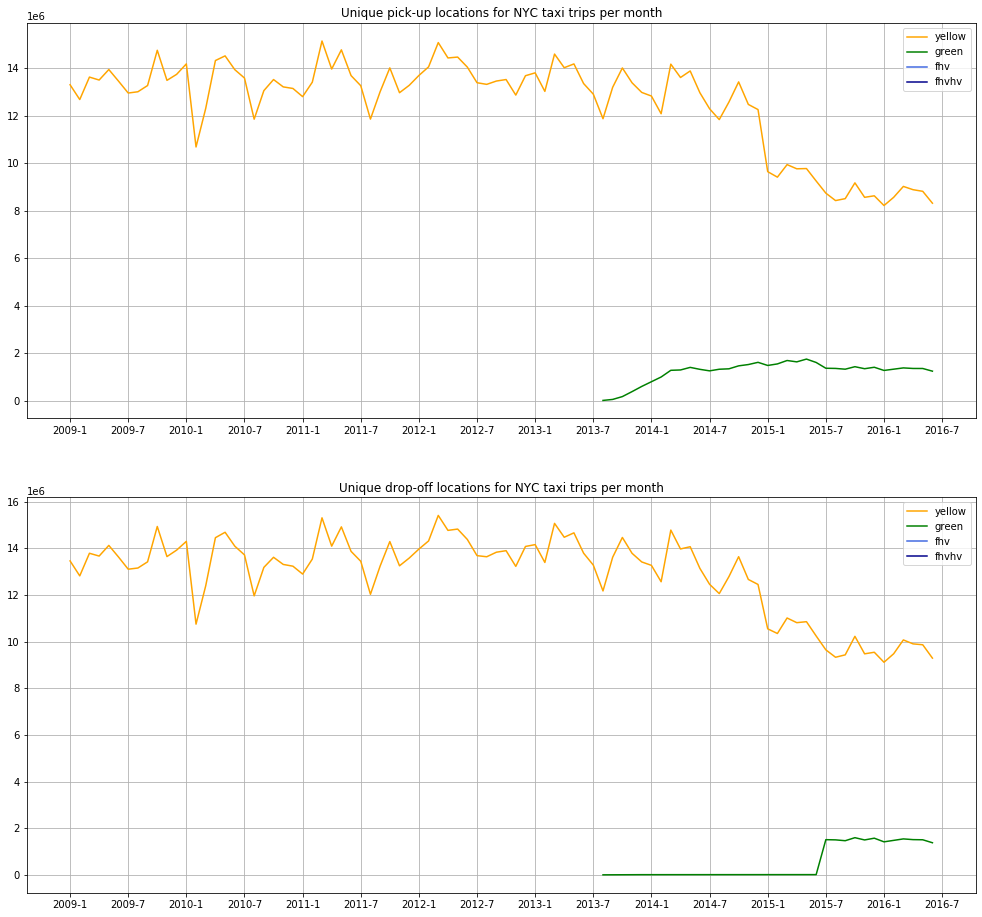

In [286]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(17, 16)
colors = {'yellow': 'orange', 'green': 'green', 'fhv': 'royalblue', 'fhvhv': 'darkblue'}

for taxi in ['yellow', 'green', 'fhv', 'fhvhv']:
    df_aux = df_colnames.loc[pd.IndexSlice[:, :, taxi],]
    x = df_aux.index.get_level_values(0).astype(str) + '-' + df_aux.index.get_level_values(1).astype(str)
    ax[0].plot(x, df_aux.loc[:, 'n_pickup_long_lat'], label=taxi, c=colors[taxi])
    ax[0].xaxis.set_major_locator(mticker.MultipleLocator(6))

ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(6, 6))
ax[0].set_title('Unique pick-up locations for NYC taxi trips per month')

for taxi in ['yellow', 'green', 'fhv', 'fhvhv']:
    df_aux = df_colnames.loc[pd.IndexSlice[:, :, taxi],]
    x = df_aux.index.get_level_values(0).astype(str) + '-' + df_aux.index.get_level_values(1).astype(str)
    ax[1].plot(x, df_aux.loc[:, 'n_dropoff_long_lat'], label=taxi, c=colors[taxi])
    ax[1].xaxis.set_major_locator(mticker.MultipleLocator(6))

ax[1].legend()
ax[1].grid()
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(6, 6))
ax[1].set_title('Unique drop-off locations for NYC taxi trips per month')

plt.show()

Unique pick-up and drop-off **zones** for taxi trips per month:

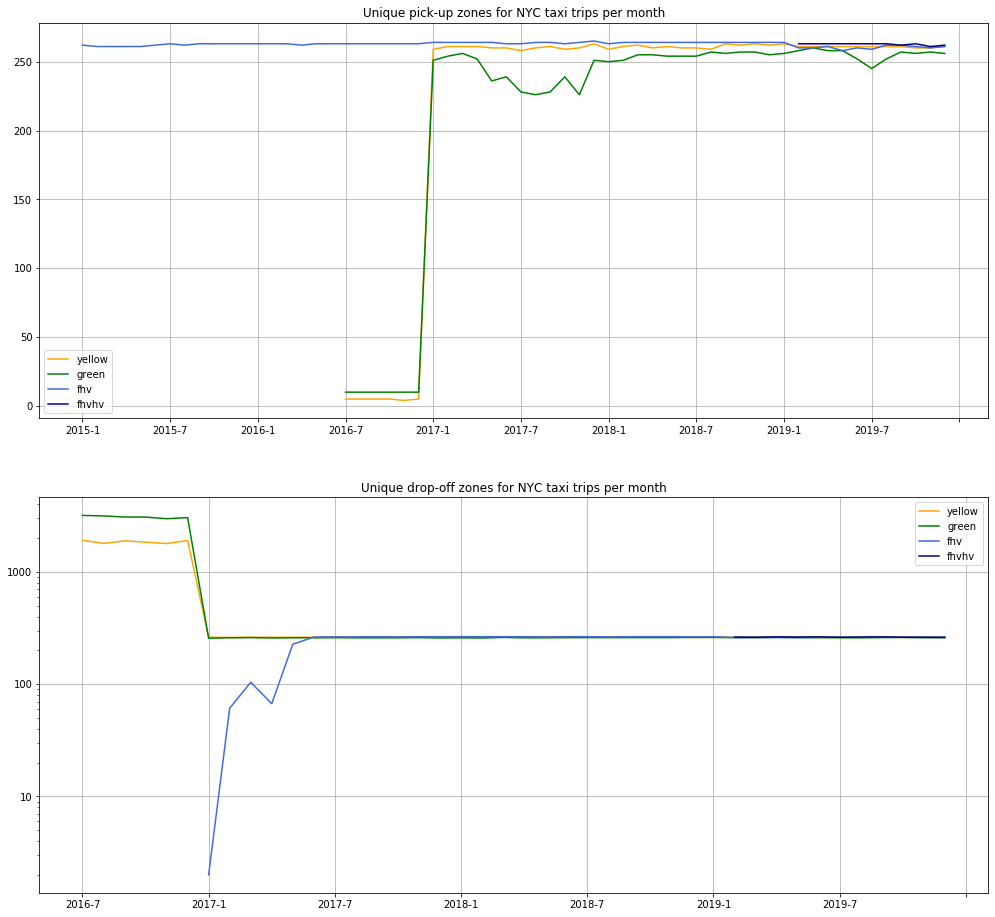

In [297]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(17, 16)
colors = {'yellow': 'orange', 'green': 'green', 'fhv': 'royalblue', 'fhvhv': 'darkblue'}

for taxi in ['yellow', 'green', 'fhv', 'fhvhv']:
    df_aux = df_colnames.loc[pd.IndexSlice[:, :, taxi],]
    x = df_aux.index.get_level_values(0).astype(str) + '-' + df_aux.index.get_level_values(1).astype(str)
    ax[0].plot(x, df_aux.loc[:, 'n_pickup'], label=taxi, c=colors[taxi])
    ax[0].xaxis.set_major_locator(mticker.MultipleLocator(6))

ax[0].legend()
ax[0].grid()
ax[0].set_title('Unique pick-up zones for NYC taxi trips per month')

for taxi in ['yellow', 'green', 'fhv', 'fhvhv']:
    df_aux = df_colnames.loc[pd.IndexSlice[:, :, taxi],]
    x = df_aux.index.get_level_values(0).astype(str) + '-' + df_aux.index.get_level_values(1).astype(str)
    ax[1].plot(x, df_aux.loc[:, 'n_dropoff'], label=taxi, c=colors[taxi])
    ax[1].xaxis.set_major_locator(mticker.MultipleLocator(6))

ax[1].legend()
ax[1].grid()
ax[1].set_yscale('log')
ax[1].yaxis.set_major_formatter(mticker.ScalarFormatter())
#ax[1].yaxis.set_major_locator(mticker.MultipleLocator(350))
ax[1].ticklabel_format(axis='y', style='plain')
ax[1].set_title('Unique drop-off zones for NYC taxi trips per month')

plt.show()

NYC zones (263) from shapefile:

## Analysing the shapefile and zones 

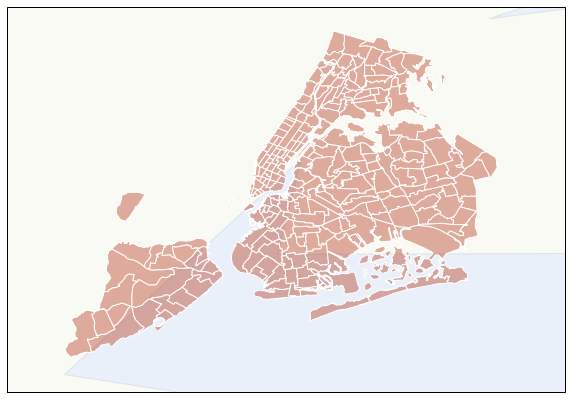

In [92]:
fname = '../data/nyc/other/nyc-shp/taxi_zones.shp'
_, _ = plt_zones(fname)

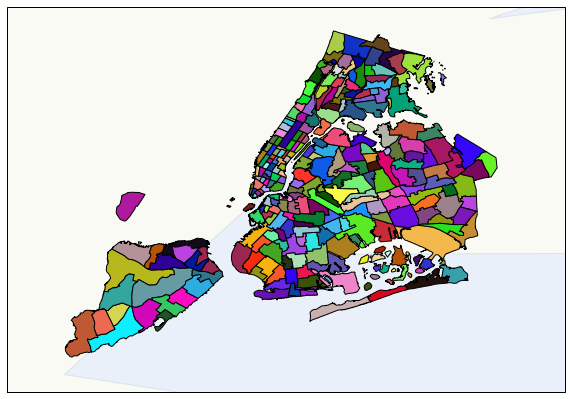

In [94]:
fname = '../data/nyc/other/nyc-shp/taxi_zones.shp'
_, _ = plt_zones(fname, colors='random')

**Caveat!** In the shapefile for NYC, there is a slight difference between LocationID and OBJECTID:

In [85]:
df_lu = pd.read_csv('../data/nyc/other/taxi_zone_lookup.csv', index_col=0)
df_lu.shape

(265, 3)

In [90]:
display(df_lu.tail())
df_lu.index.nunique()

,Borough,Zone,service_zone
LocationID,,,
261,Manhattan,World Trade Center,Yellow Zone
262,Manhattan,Yorkville East,Yellow Zone
263,Manhattan,Yorkville West,Yellow Zone
264,Unknown,NV,NaN
265,Unknown,NaN,NaN


265

In [87]:
df_lu[df_lu.duplicated(keep=False)]

,Borough,Zone,service_zone
LocationID,,,
56,Queens,Corona,Boro Zone
57,Queens,Corona,Boro Zone
103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
104,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone


However, in the shapefile:
- Rows 56 and 57 appear with OBJECTID 56 and 57, but LocationID is 56 for both of them!
- Rows 103, 104 and 105 appear with OBJECTID 103, 104 and 105, but LocationID is 103 for all of them!

Conclusion:
- The `taxi_zone_lookup.csv` presents no problem.
- When working with the shapefile, use OBJECTID.

## Some EDA

### Locations for the 2nd half of 2016

Check low and high values in pick-up and drop-off zones (respectively) for yellow and green taxis on the second half of 2016:

In [320]:
df_colnames.loc[(2016, range(7, 13), ['yellow', 'green']), ]

shape  \
year month taxi                     
2016 7     yellow  (10294080, 17)   
           green    (1332510, 19)   
     8     yellow   (9942263, 17)   
           green    (1247675, 19)   
     9     yellow  (10116018, 17)   
           green    (1162373, 19)   
     10    yellow  (10854626, 17)   
           green    (1252572, 19)   
     11    yellow  (10102128, 17)   
           green    (1148214, 19)   
     12    yellow  (10449408, 17)   
           green    (1224158, 19)   

                                                             columns n_pickup  \
year month taxi                                                                 
2016 7     yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...        5   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...       10   
     8     yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...        5   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...       10   
     9     yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...        5   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...       10   
     10    yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...        5   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...       10   
     11    yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...        4   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...       10   
     12    yellow  ['VendorID' 'tpep_pickup_datetime' 'tpep_dropo...        5   
           green   ['VendorID' 'lpep_pickup_datetime' 'lpep_dropo...       10   

                  n_dropoff n_pickup_long_lat n_dropoff_long_lat  
year month taxi                                                   
2016 7     yellow      1916               NaN                NaN  
           green       3191               NaN                NaN  
     8     yellow      1796               NaN                NaN  
           green       3159               NaN                NaN  
     9     yellow      1893               NaN                NaN  
           green       3089               NaN                NaN  
     10    yellow      1844               NaN                NaN  
           green       3085               NaN                NaN  
     11    yellow      1792               NaN                NaN  
           green       2983               NaN                NaN  
     12    yellow      1907               NaN                NaN  
           green       3052               NaN                NaN

In [321]:
year, month, taxi = 2016, 12, 'yellow'
df = pd.read_csv('../data/nyc/raw/{:04}{:02}_{}.csv'.format(year, month, taxi), error_bad_lines=False)
print('pick-up min/max:', df.PULocationID.min(), '/', df.PULocationID.max())
print('drop-off min/max:', df.DOLocationID.min(), '/', df.DOLocationID.max())

pick-up min/max: 1 / 5
drop-off min/max: -450.0 / 23618.96


In [323]:
year, month, taxi = 2016, 8, 'green'
df = pd.read_csv('../data/nyc/raw/{:04}{:02}_{}.csv'.format(year, month, taxi), error_bad_lines=False)
print('pick-up min/max:', df.PULocationID.min(), '/', df.PULocationID.max())
print('drop-off min/max:', df.DOLocationID.min(), '/', df.DOLocationID.max())

pick-up min/max: 0 / 9
drop-off min/max: 0.0 / 139.55
